In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

In [3]:
current_dir = os.getcwd()  # Get the current working directory
dataset_dir = os.path.join(current_dir, 'cityscapes_data')  # Path to the cityscapes_data directory
train_dir = os.path.join(dataset_dir, 'train')  # Path to the train subdirectory
val_dir = os.path.join(dataset_dir, 'val')  # Path to the val subdirectory
width = 512
height = 256

In [7]:
def load_image_and_mask(image_path):
    # Ensure the image_path is a string (debugging step)
    print(f"Loading image from: {image_path}")
    image_path = str(image_path)  # Ensure it's a string if it is not

    # Read the image file (assuming it contains RGB + mask in the same file)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=4)  # Assuming the image has 4 channels (RGB + Mask)

    # Split the image into real image (RGB) and mask (Grayscale)
    real_image = image[:, :, :3]  # Take the first 3 channels for the real image (RGB)
    mask = image[:, :, 3:]       # Take the 4th channel as the mask (single channel)

    # Resize both real image and mask
    real_image = tf.image.resize(real_image, (width, height))
    mask = tf.image.resize(mask, (width, height))

    # Normalize the real image (divide by 255 for range [0, 1])
    real_image = tf.cast(real_image, dtype=tf.float32) / 255.0

    # Normalize mask if necessary (e.g., if the mask has pixel values 0-255, normalize them to [0, 1])
    mask = tf.cast(mask, dtype=tf.float32)  # Optionally normalize mask if needed (e.g., to range [0, 1])

    return real_image, mask

# Function to load dataset from a directory
def load_dataset_from_directory(directory):
    # Get all image paths in the directory (ensure the paths are strings)
    image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.png')]
    
    # Check that image paths are valid strings
    image_paths = [str(path) for path in image_paths]  # Ensure paths are strings

    # Create a TensorFlow dataset from the image paths
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Map the function to load images and masks
    dataset = dataset.map(lambda image_path: load_image_and_mask(image_path))

    return dataset

# Load the train and validation datasets
train_ds = load_dataset_from_directory(train_dir)
val_ds = load_dataset_from_directory(val_dir)

# Apply data augmentation and normalization for training
def load_train_ds(dataset):
    def _process(image, mask):
        # Apply data augmentation (e.g., flipping)
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        # You can apply further augmentations or transformations if needed
        return image, mask

    return dataset.map(_process)

# Apply transformations to training dataset
train_ds = load_train_ds(train_ds)

# Batch and prefetch for better performance
train_ds = train_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Optional: Print out dataset shapes for debugging
for image, mask in train_ds.take(1):
    print(image.shape, mask.shape) 

Loading image from: Tensor("args_0:0", shape=(), dtype=float32)
Loading image from: Tensor("args_0:0", shape=(), dtype=float32)


In [9]:
TRAIN_LENGTH = len([fname for fname in os.listdir(train_dir) if fname.endswith('.png')])

# Set the batch size
BATCH_SIZE = 64

Nombre d'images chargées : 2975 / 2975
Nombre d'images chargées : 500 / 500


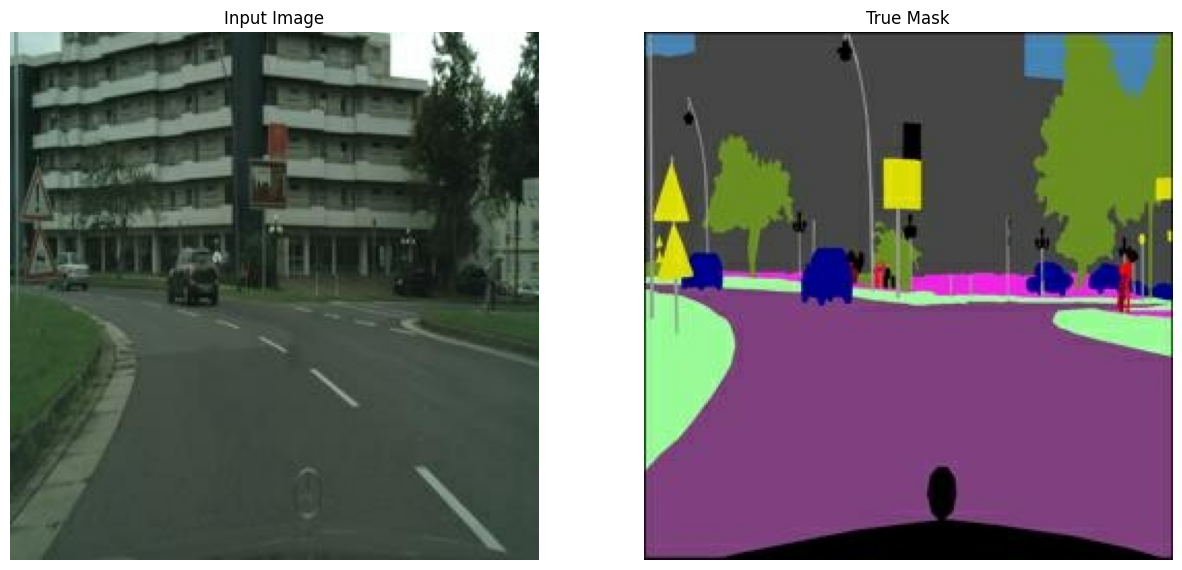

In [8]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# Fonction pour lire et charger l'image
def load_image(image_path):
    # Vérifiez que image_path est bien une chaîne de caractères
    if isinstance(image_path, str):  # Vérifier si c'est une chaîne de caractères
        try:
            image = tf.io.read_file(image_path)  # Lire le fichier
            image = tf.image.decode_jpeg(image, channels=3)  # Décode l'image en format JPEG
            return image
        except Exception as e:
            print(f"Erreur lors du chargement de l'image {image_path}: {e}")
            return None  # Retourner None si l'image ne peut pas être chargée
    else:
        print(f"Chemin d'image invalide: {image_path}")
        return None

# Liste des chemins des images dans le répertoire
train_dir ="C:\\Users\\ranim\\Documents\\JupyterNotebook\\ImageSegmentationProject\\cityscapes_data\\train"
val_dir ="C:\\Users\\ranim\\Documents\\JupyterNotebook\\ImageSegmentationProject\\cityscapes_data\\val"

train_images_paths = [os.path.join(train_dir, fname) for fname in os.listdir(train_dir) if fname.endswith('.jpg')]
test_images_paths = [os.path.join(val_dir, fname) for fname in os.listdir(val_dir) if fname.endswith('.jpg')]

# Liste pour stocker les images chargées
loaded_train_images = []
loaded_test_images = []

# Charger les images avec gestion des erreurs
for path in train_images_paths:
    image = load_image(path)
    if image is not None:
       loaded_train_images.append(image)
for path in test_images_paths:
    image = load_image(path)
    if image is not None:
       loaded_test_images.append(image)

# Vérifier si toutes les images ont été chargées
print(f"Nombre d'images chargées : {len(loaded_train_images)} / {len(train_images_paths)}")
print(f"Nombre d'images chargées : {len(loaded_test_images)} / {len(test_images_paths)}")
def split_image_and_mask(combined_image):
    """
    Splits the input image into the actual image and the mask.
    Assumes the combined image is stacked along the width (side-by-side).
    """
    image_width = tf.shape(combined_image)[1] // 2  # Assuming the width is double for combined input
    input_image = combined_image[:, :image_width]  # Left part: input image
    mask = combined_image[:, image_width:]        # Right part: mask
    return input_image, mask


def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()


# Example: Load or define the dataset

for combined_image in loaded_train_images[:1]:  # Take the first example from the list
    sample_image, sample_mask = split_image_and_mask(combined_image)  # Split into image and mask
    display_list = [sample_image, sample_mask]  # Add predicted mask if available

display_images(display_list)